# Linear Regression Demo (Python)

This notebook mirrors your presentation:
1) Simple Linear Regression (OLS, RSS, R², RSE)
2) Assumption diagnostics (residuals, normality)
3) Confidence intervals & t-tests
4) Multiple Linear Regression (Adj-R², AIC, BIC)
5) Collinearity illustration (VIF)

Synthetic 'Advertising-like' data are generated so it runs anywhere.

In [1]:

# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm # librairie for linear regression / need to add intercept 
import statsmodels.formula.api as smf # intercept is incorporate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [2]:

# For nice tables in notebooks (optional, safe if not installed)
try:
    from IPython.display import display
except:
    display = print


In [3]:
# 1) Generate synthetic "Advertising" dataset
np.random.seed(42)
n = 200
TV = np.random.uniform(0, 300, n)
Radio = np.random.uniform(0, 50, n)
Newspaper = np.random.uniform(0, 100, n)

beta0, beta_tv, beta_radio, beta_news = 3.0, 0.05, 0.2, 0.0
sigma = 2.5
Sales = beta0 + beta_tv*TV + beta_radio*Radio + beta_news*Newspaper + np.random.normal(0, sigma, n)

In [4]:
df = pd.DataFrame({"Sales": Sales, "TV": TV, "Radio": Radio, "Newspaper": Newspaper})
display(df.head())
print("Dataset shape:", df.shape)
print(df.describe())

,Sales,TV,Radio,Newspaper
0,13.712774,112.362036,32.101582,10.312387
1,16.119932,285.214292,4.206998,90.255291
2,15.328620,219.598183,8.081436,50.525237
3,18.377313,179.597545,44.927709,82.645747
4,10.020447,46.805592,30.321453,32.004960


Dataset shape: (200, 4)
            Sales          TV       Radio   Newspaper
count  200.000000  200.000000  200.000000  200.000000
mean    15.155104  145.201870   25.218757   52.067278
std      5.689171   88.467429   14.650060   30.730879
min     -1.080195    1.656635    0.253079    1.083765
25%     10.348136   68.574724   13.073125   25.552032
50%     15.578877  148.345876   27.081994   52.539948
75%     19.460254  227.057885   37.109966   81.111489
max     27.095853  296.066081   49.525257   99.971767


In [5]:
# 2) Simple Linear Regression: Sales ~ TV
model_slr = smf.ols("Sales ~ TV", data=df).fit()
print(model_slr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     265.7
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.92e-38
Time:                        10:36:42   Log-Likelihood:                -545.90
No. Observations:                 200   AIC:                             1096.
Df Residuals:                     198   BIC:                             1102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0867      0.507     15.937      0.0


R-squared = 0.573: about 57% of the variability in sales is explained by the TV budget.

Adj. R-squared = 0.571: very close to R² → the model is not overfitted (only one predictor).

F-statistic = 265.7, p-value ≈ 1.9e-38: the model is globally highly significant → at least one coefficient ≠ 0.

Coefficients

Intercept (β₀ = 8.09, p < 0.001):
When TV = 0, the predicted sales are ≈ 8 units (statistically significant, CI \[7.086 ; 9.087]).

TV (β₁ = 0.0487, p < 0.001):
Each additional \$1,000 spent on TV advertising increases sales by ≈ 48.7 units on average.
Highly significant (p ≈ 0, CI \[0.043 ; 0.055]).

Residual diagnostics

Omnibus / Jarque-Bera (JB) tests: high p-values (0.600 and 0.592) → no evidence against residual normality.
Durbin-Watson = 1.93: close to 2 → no residual autocorrelation.
Skew ≈ -0.17, Kurtosis ≈ 2.9: residuals are nearly normal (skew ≈ 0, kurtosis ≈ 3).
AIC = 1096, BIC = 1102: information criteria (lower = better, useful for model comparison).

Conclusion:
The model is robust, well-specified, and statistically significant.
TV advertising explains a substantial share of sales variability (57%), and the effect is clear: + \$1,000 in TV ads → +48.7 sales.
Basic assumptions (normality, independence) appear to be satisfied.




In [6]:
# Manual metrics
y = df["Sales"].values
y_hat = model_slr.fittedvalues.values
residuals = model_slr.resid.values
RSS = np.sum(residuals**2)
TSS = np.sum((y - y.mean())**2)
R2 = 1 - RSS/TSS
RSE = np.sqrt(RSS/(len(y)-2))


print("\nManual metrics for SLR (Sales ~ TV)")
print(f"RSS = {RSS:.3f}")
print(f"TSS = {TSS:.3f}")
print(f"R^2 = {R2:.4f}")
print(f"RSE = {RSE:.4f}")


Manual metrics for SLR (Sales ~ TV)
RSS = 2750.181
TSS = 6440.966
R^2 = 0.5730
RSE = 3.7269


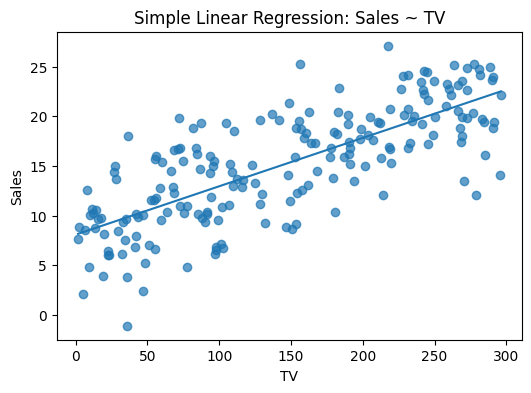

In [7]:
# Plot: scatter + fitted line
plt.figure(figsize=(6,4))
plt.scatter(df["TV"], df["Sales"], alpha=0.7)
x_line = np.linspace(df["TV"].min(), df["TV"].max(), 200)
y_line = model_slr.params["Intercept"] + model_slr.params["TV"]*x_line
plt.plot(x_line, y_line)
plt.xlabel("TV"); plt.ylabel("Sales"); plt.title("Simple Linear Regression: Sales ~ TV")
plt.show()


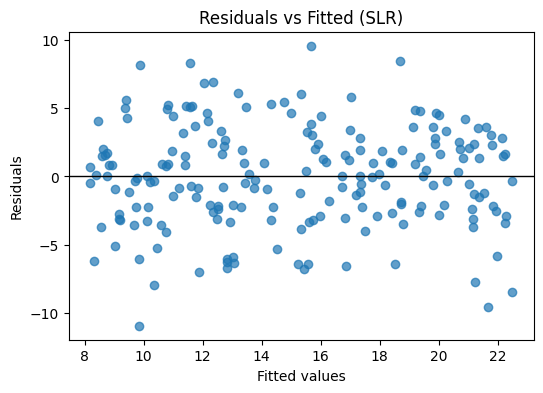

In [8]:
# 3) Assumptions diagnostics (SLR)
plt.figure(figsize=(6,4))
plt.scatter(y_hat, residuals, alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (SLR)")
plt.show()



Goal: check the homoscedasticity assumption. The residuals must be randomly distributed around 0 with no visible structure.

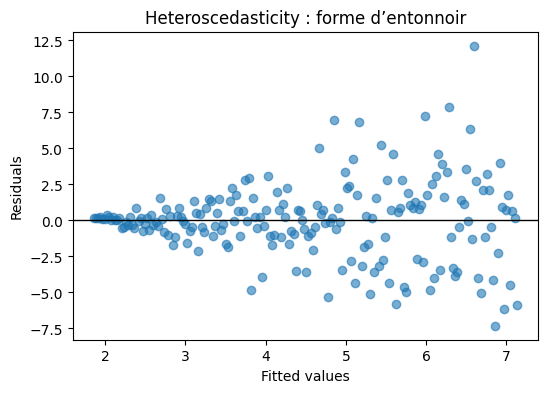

In [9]:
# Case of random variable with non-constant variance (funnel)# Generation of data with heteroscedasticity
np.random.seed(42)
X = np.linspace(0, 10, 200)
eps = np.random.normal(0, 0.5 * X)  
y = 2 + 0.5 * X + eps

# Régression linéaire
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
y_hat = model.fittedvalues
residuals = model.resid

# Résidus vs valeurs ajustées
plt.figure(figsize=(6,4))
plt.scatter(y_hat, residuals, alpha=0.6)
plt.axhline(0, color='k', lw=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Heteroscedasticity : forme d’entonnoir")
plt.show()

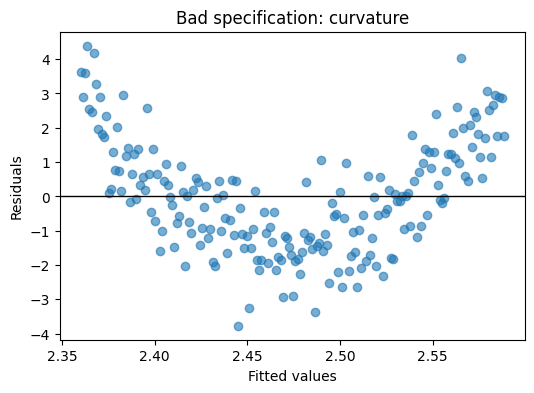

In [10]:
# Generation of non-linear data
np.random.seed(42)
X = np.linspace(-3, 3, 200)
eps = np.random.normal(0, 1, 200)
y = 1 + 0.5 * X**2 + eps  # quadratic relation

#Linear regression (bad specification)
X_const = sm.add_constant(X)  # only X (not X²)
model = sm.OLS(y, X_const).fit()
y_hat = model.fittedvalues
residuals = model.resid

# Residuals vs adjusted values
plt.figure(figsize=(6,4))
plt.scatter(y_hat, residuals, alpha=0.6)
plt.axhline(0, color='k', lw=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Bad specification: curvature")
plt.show()


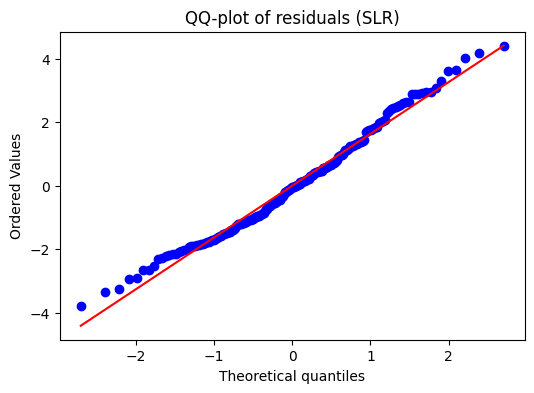

In [11]:
#To verify if the residues follow a normal distribution (theoretical quantile comparison of a normal distribution and model residues)
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot of residuals (SLR)")
plt.show()


The points generally align well on the red line → this means that the distribution of the residuals is close to a normal distribution.At the extremes (top right / bottom left), we observe some slight deviations → this is normal and common in real data. It just means that the tails are slightly different from a perfect normal distribution.

In [12]:
sh_w, sh_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk: W={sh_w:.3f}, p-value={sh_p:.4f}")
dw = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.3f} (≈2 suggests little autocorrelation)")

Shapiro-Wilk: W=0.984, p-value=0.0263
Durbin-Watson: 0.686 (≈2 suggests little autocorrelation)


Shapiro-Wilk test : H0 = les résidus suivent une loi normale.

Si p-value > 0.05 → on ne rejette pas H0 → normalité OK.

In [13]:
# 4) CI & t-test (SLR)
print("95% Confidence intervals (SLR):")
print(model_slr.conf_int(alpha=0.05))
print("\nTV slope t-test:")
print(f"beta1={model_slr.params['TV']:.4f}, SE={model_slr.bse['TV']:.4f}, t={model_slr.tvalues['TV']:.2f}, p={model_slr.pvalues['TV']:.3e}")

95% Confidence intervals (SLR):
                  0         1
Intercept  7.086052  9.087339
TV         0.042791  0.054569

TV slope t-test:
beta1=0.0487, SE=0.0030, t=16.30, p=1.919e-38


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     265.6
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           9.03e-69
Time:                        10:36:43   Log-Likelihood:                -468.77
No. Observations:                 200   AIC:                             945.5
Df Residuals:                     196   BIC:                             958.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8596      0.595      4.809      0.0

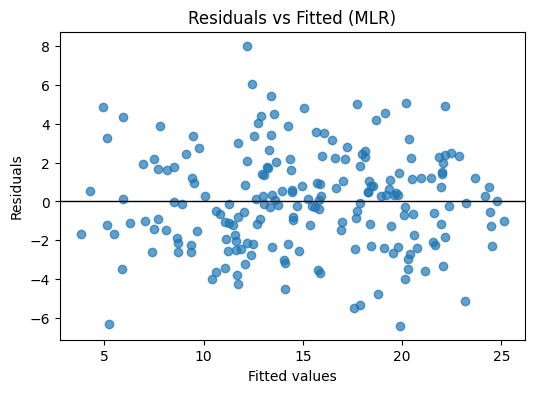

In [14]:
# 5) Multiple Linear Regression
model_mlr = smf.ols("Sales ~ TV + Radio + Newspaper", data=df).fit()
print(model_mlr.summary())

print("\nKey metrics (MLR):")
print(f"R^2       : {model_mlr.rsquared:.4f}")
print(f"Adj. R^2  : {model_mlr.rsquared_adj:.4f}")
print(f"AIC       : {model_mlr.aic:.2f}")
print(f"BIC       : {model_mlr.bic:.2f}")
print(f"F-stat    : {model_mlr.fvalue:.2f}, p={model_mlr.f_pvalue:.3e}")
rss_mlr = np.sum(model_mlr.resid.values**2)
n = df.shape[0]; p = 3
rse_mlr = np.sqrt(rss_mlr/(n-p-1))
print(f"RSE       : {rse_mlr:.4f}")

plt.figure(figsize=(6,4))
plt.scatter(model_mlr.fittedvalues, model_mlr.resid, alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (MLR)")
plt.show()

In [15]:

# 6) Collinearity illustration (VIF)
df["TV2_highly_corr"] = df["TV"] + np.random.normal(0, 3, size=n)  # we create a variable artificially correlated with TV
model_col = smf.ols("Sales ~ TV + TV2_highly_corr + Radio + Newspaper", data=df).fit()
print(model_col.summary())

X = sm.add_constant(df[["TV","TV2_highly_corr","Radio","Newspaper"]])  # Regression with collinearity



                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     198.8
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.23e-67
Time:                        10:36:43   Log-Likelihood:                -468.50
No. Observations:                 200   AIC:                             947.0
Df Residuals:                     195   BIC:                             963.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8451      0.596     

TV: coeff = -0.0283, not significant (p=0.652). TV2_highly_corr: coeff = 0.0782, not significant (p=0.216). While in the simple model, TV was very significant! Here, the model cannot decide what coefficient to assign to TV or TV2_highly_corr, as they say practically the same thing → both lose significance.

In [16]:
# 7) Model comparison table
summary_tbl = pd.DataFrame({
    "Model": ["SLR: Sales~TV", "MLR: Sales~TV+Radio+News", "Collinearity: +TV2"],
    "R2": [model_slr.rsquared, model_mlr.rsquared, model_col.rsquared],
    "Adj_R2": [model_slr.rsquared_adj, model_mlr.rsquared_adj, model_col.rsquared_adj],
    "AIC": [model_slr.aic, model_mlr.aic, model_col.aic],
    "BIC": [model_slr.bic, model_mlr.bic, model_col.bic],
    "RSE": [np.sqrt(np.sum(model_slr.resid**2)/(n-2)),
            np.sqrt(np.sum(model_mlr.resid**2)/(n-3-1)),
            np.sqrt(np.sum(model_col.resid**2)/(n-4-1))]
})
display(summary_tbl.round(3))


,Model,R2,Adj_R2,AIC,BIC,RSE
0,SLR: Sales~TV,0.573,0.571,1095.796,1102.393,3.727
1,MLR: Sales~TV+Radio+News,0.803,0.800,945.538,958.731,2.547
2,Collinearity: +TV2,0.803,0.799,946.994,963.485,2.550



#### 1. SLR: Sales ~ TV
- ( R^2 = 0.573 ) → the model explains only ~57% of the variance.
- ( RSE = 3.727 ) → fairly large prediction errors.
- Very high AIC/BIC → low-performance model.

#### 2. MLR: Sales ~ TV + Radio + News
- ( R^2 = 0.803 ), ( Adj R^2 = 0.800 ) → big improvement: we explain 80% of the variance.
- ( RSE = 2.547 ) → the model is much more accurate.
- AIC/BIC greatly reduce → better compromise between precision and complexity.

#### 3. Collinearity: + TV2 (addition of a collinear variable)
- ( R^2 ) climbs very slightly (0.803 → 0.804), **almost no improvement**.
- ( Adj R^2 ) remains the same (0.800) → the gain is artificial.
- BIC increases (962 > 958) → the criterion penalizes unnecessary addition.
- ( RSE ) remains unchanged.